## Mixture of Gaussians

### Covariance Types

 * Spherical : Each component has its own single variance 
 * Diag : Each Component has its own diagonal variance 
 * Tied : All components share the variance matrix
 * Full : Each component has its own full variance matrix


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats
import logging
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [2]:
pd.options.display.float_format = "{:.3f}".format

In [3]:
%matplotlib inline

In [4]:
sns.set()

In [5]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


In [6]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=200, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)


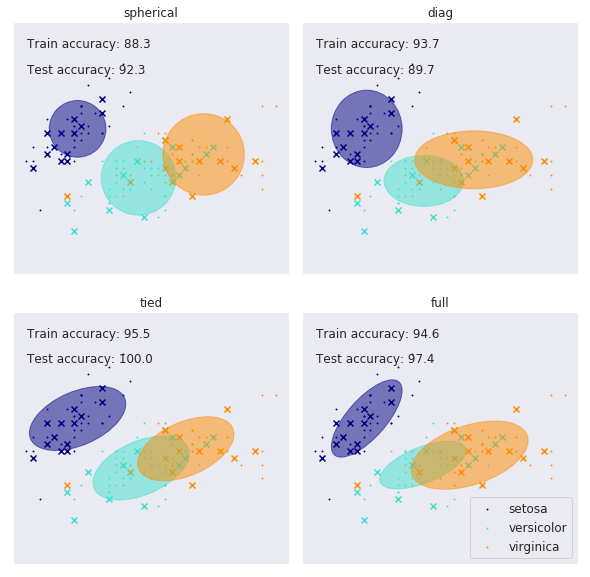

In [7]:

plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


In [8]:
for k, e in estimators.items():
    print(k)
    print(e.means_)
    print(e.covariances_)
    #print(e.bic(X_train), e.aic(X_train))
    print()

spherical
[[5.04594595 3.46486481 1.46216224 0.2594595 ]
 [5.92303561 2.75863708 4.42746633 1.44168512]
 [6.86162683 3.09677892 5.72371016 2.09864346]]
[0.08346343 0.14435206 0.17239489]

diag
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.86837133 2.71488031 4.24038172 1.29353618]
 [6.58808611 3.01891549 5.44185513 2.00163625]]
[[0.13005213 0.15525301 0.03640714 0.01214125]
 [0.16369568 0.06735135 0.2402562  0.0274263 ]
 [0.36224898 0.08698084 0.32957695 0.08041491]]

tied
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.96087873 2.75163079 4.35808487 1.33550178]
 [6.60469867 3.0286944  5.5131432  2.07615017]]
[[0.24091895 0.07263283 0.16722309 0.03249014]
 [0.07263283 0.10630611 0.03587004 0.01610236]
 [0.16722309 0.03587004 0.22279522 0.04473411]
 [0.03249014 0.01610236 0.04473411 0.03365396]]

full
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.8536386  2.79390955 4.14872947 1.27451352]
 [6.52946208 2.93599699 5.38973172 1.94704675]]
[[[0.13005213 0.1026954  0.01660336 0.

In [9]:
e.n_components

3

In [10]:
e.sample()

(array([[5.86889957, 2.78306226, 3.29646466, 1.0727691 ]]), array([1]))

In [11]:
import sys
import math

In [12]:
import sklearn.cluster

In [13]:
kmeans = sklearn.cluster.KMeans(n_clusters=3)

In [14]:
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
data = iris["data"]

In [16]:
kmeans.cluster_centers_

array([[6.87307692, 3.1       , 5.74230769, 2.09230769],
       [5.04594595, 3.46486486, 1.46216216, 0.25945946],
       [5.92083333, 2.75833333, 4.42291667, 1.44791667]])

In [17]:
predicted = kmeans.predict(X_train)

In [18]:
for i in sorted(predicted):
    these = i == predicted

In [19]:
X_train[these]

array([[6.1, 2.9, 4.7, 1.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.7, 3.1, 4.4, 1.4],
       [5.6, 3. , 4.5, 1.5],
       [5.8, 2.7, 4.1, 1. ],
       [6.2, 2.2, 4.5, 1.5],
       [5.6, 2.5, 3.9, 1.1],
       [5.9, 3.2, 4.8, 1.8],
       [6.1, 2.8, 4. , 1.3],
       [6.3, 2.5, 4.9, 1.5],
       [6.1, 2.8, 4.7, 1.2],
       [6.4, 2.9, 4.3, 1.3],
       [6.6, 3. , 4.4, 1.4],
       [6.8, 2.8, 4.8, 1.4],
       [6. , 2.9, 4.5, 1.5],
       [5.7, 2.6, 3.5, 1. ],
       [5.5, 2.4, 3.8, 1.1],
       [5.5, 2.4, 3.7, 1. ],
       [5.8, 2.7, 3.9, 1.2],
       [6. , 2.7, 5.1, 1.6],
       [5.4, 3. , 4.5, 1.5],
       [6. , 3.4, 4.5, 1.6],
       [6.7, 3.1, 4.7, 1.5],
       [6.3, 2.3, 4.4, 1.3],
       [5.6, 3. , 4.1, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [5.5, 2.6, 4.4, 1.2],
       [6.1, 3. , 4.6, 1.4],
       [5.8, 2.6, 4. , 1.2],
       [5. , 2.3, 3.3, 1. ],
       [5.6, 2.7, 4.2, 1.3],
       [5.7, 3. , 4.2, 1.2],
       [5.7, 2.9, 4.2, 1.3],
       [6.2, 2.9, 4.3, 1.3],
       [5.1, 2

In [20]:
np.cov(X_train[0].T).shape

()

In [21]:
X_train.shape

(111, 4)

In [23]:
import sys


In [24]:
sys.path.insert(0, "../")

In [27]:
from hmm.datasets.basic import load_old_faithful_waiting

In [29]:
waiting  = load_old_faithful_waiting()

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


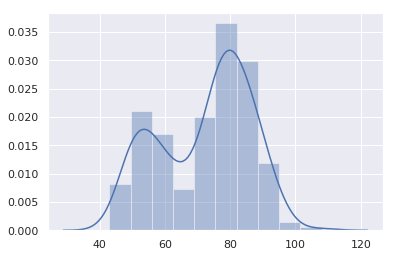

In [30]:
sns.distplot(waiting["data"])

In [31]:
from hmm import GaussianVariationalHMM

In [32]:
one = GaussianVariationalHMM.GaussianVariationalHMM(n_components=4)

In [34]:
one.fit(waiting["data"].reshape(1, -1))

[10. 10. 10. 10.]
[57.  29.5 38.5 24.5]
[582.87168142 217.98275862 692.97368421 388.1875    ]
[0.1 0.1 0.1 0.1]


GaussianVariationalHMM(A_prior=None, implementation='scaling',
            means_prior=None, min_a_value=None, n_components=4, n_inits=1,
            n_iterations=100, n_jobs=-1, n_samples_prior=None,
            pi_prior=None, random_state=None, tol=1e-06,
            variances_prior=None, verbose=0)

In [35]:
one.means_posterior_

array([77.46540795, 51.43857826, 88.22658863, 61.98629294])

In [36]:
one.variances_posterior_

array([10.56035378, 12.63569717, 18.03014792, 14.7368883 ])

In [37]:
one.A_counts_


array([[53.25000062, 22.25002837, 11.25000004, 33.24997322],
       [24.25000899,  0.25      , 35.25004749,  0.25      ],
       [18.250002  , 36.25002996,  1.25      , 16.24996805],
       [24.24999065,  1.24999815, 24.24995247,  0.25      ]])

In [39]:
one.means_prior_

array([72.31438127, 72.31438127, 72.31438127, 72.31438127])

In [73]:
rvs = scipy.stats.gamma(10**3, scale=1/10**3).rvs(100)

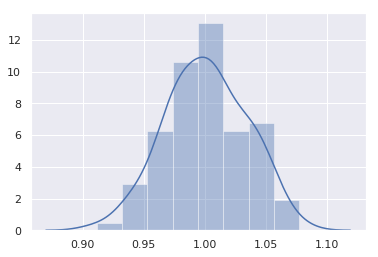

In [74]:
sns.distplot(rvs)

In [75]:
rvs

array([0.98057985, 1.01054562, 0.97665948, 0.97853972, 1.0577767 ,
       0.93672378, 0.95543189, 1.00342643, 0.98398553, 1.0265532 ,
       1.05143136, 0.96067859, 1.0490843 , 0.98798414, 0.97618837,
       1.03949164, 0.97764606, 0.99078639, 1.06400291, 0.9638146 ,
       0.98320733, 0.9753636 , 1.02336516, 0.95877993, 0.95832126,
       0.96892283, 1.00218918, 1.00196826, 0.97361415, 0.96923256,
       1.00693289, 0.99774619, 0.98318261, 1.04735496, 1.03642838,
       1.00065953, 1.03013751, 1.04259773, 0.99775162, 1.04568387,
       0.98407644, 1.02990606, 0.99723743, 0.97902949, 0.96071151,
       0.96837493, 1.05479455, 0.93914984, 1.00115548, 1.01349395,
       0.97192105, 1.01383932, 1.00557596, 1.01125713, 0.97266552,
       1.0076093 , 0.98033973, 1.00952082, 0.93578923, 1.00510311,
       1.04344453, 1.04035735, 0.911597  , 1.00438686, 1.03335272,
       1.05796309, 0.99006316, 1.00399411, 1.02057728, 1.00727128,
       1.02712828, 1.01868113, 0.98704027, 0.97078687, 0.99774

In [64]:
sum(rvs)

2.3243180132904384e-52